## Data Akuisisi

In [1]:
# !pip uninstall -y kagglehub
# !pip install kagglehub==0.3.13

In [2]:
import kagglehub
import os
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.tools import add_constant
import statsmodels.api as sm
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, zscore, norm, shapiro, kruskal

C:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pastikan file kaggle.json ada di C:\Users\<namaakun>\.kaggle

In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
# api = KaggleApi()
# api.authenticate()

# dataset = "uom190346a/sleep-health-and-lifestyle-dataset"
# folder_tujuan = "data"
# api.dataset_download_files(dataset, path=folder_tujuan, unzip=True)

# print(f"Dataset berhasil di-download ke folder: {folder_tujuan}")

In [5]:
df = pd.read_csv(f'data/Sleep_health_and_lifestyle_dataset.csv')
df.head(2)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN


In [6]:
df.info()
df['Sleep Disorder'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

Sleep Disorder: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).

In [7]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
df[['Systolic Pressure', 'Diastolic Pressure']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df_corr = df.drop(columns=['Person ID', 'Blood Pressure'])

df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           374 non-null    object 
 11  Systolic Pressure        374 non-null    int64  
 12  Diastolic Pressure       374 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 38.1+ KB


In [8]:
df['Sleep Disorder'].value_counts()

Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

### Distribusi

In [9]:
categorical_vars = ['Gender', 'Occupation', 'Quality of Sleep', 'Stress Level', 'BMI Category']
target = 'Sleep Disorder'
numerical_vars = [col for col in df_corr.columns if col not in categorical_vars + [target] and df_corr[col].dtype in ['int64', 'float64']]

scale_map = {
    'Gender': 'Nominal',
    'Age': 'Rasio',
    'Occupation': 'Nominal',
    'Sleep Duration': 'Rasio',
    'Quality of Sleep': 'Ordinal',
    'Physical Activity Level': 'Rasio',
    'Stress Level': 'Ordinal',
    'BMI Category': 'Ordinal',
    'Heart Rate': 'Rasio',
    'Daily Steps': 'Rasio',
    'Sleep Disorder': 'Nominal',
    'Systolic Pressure': 'Rasio',
    'Diastolic Pressure': 'Rasio'
}

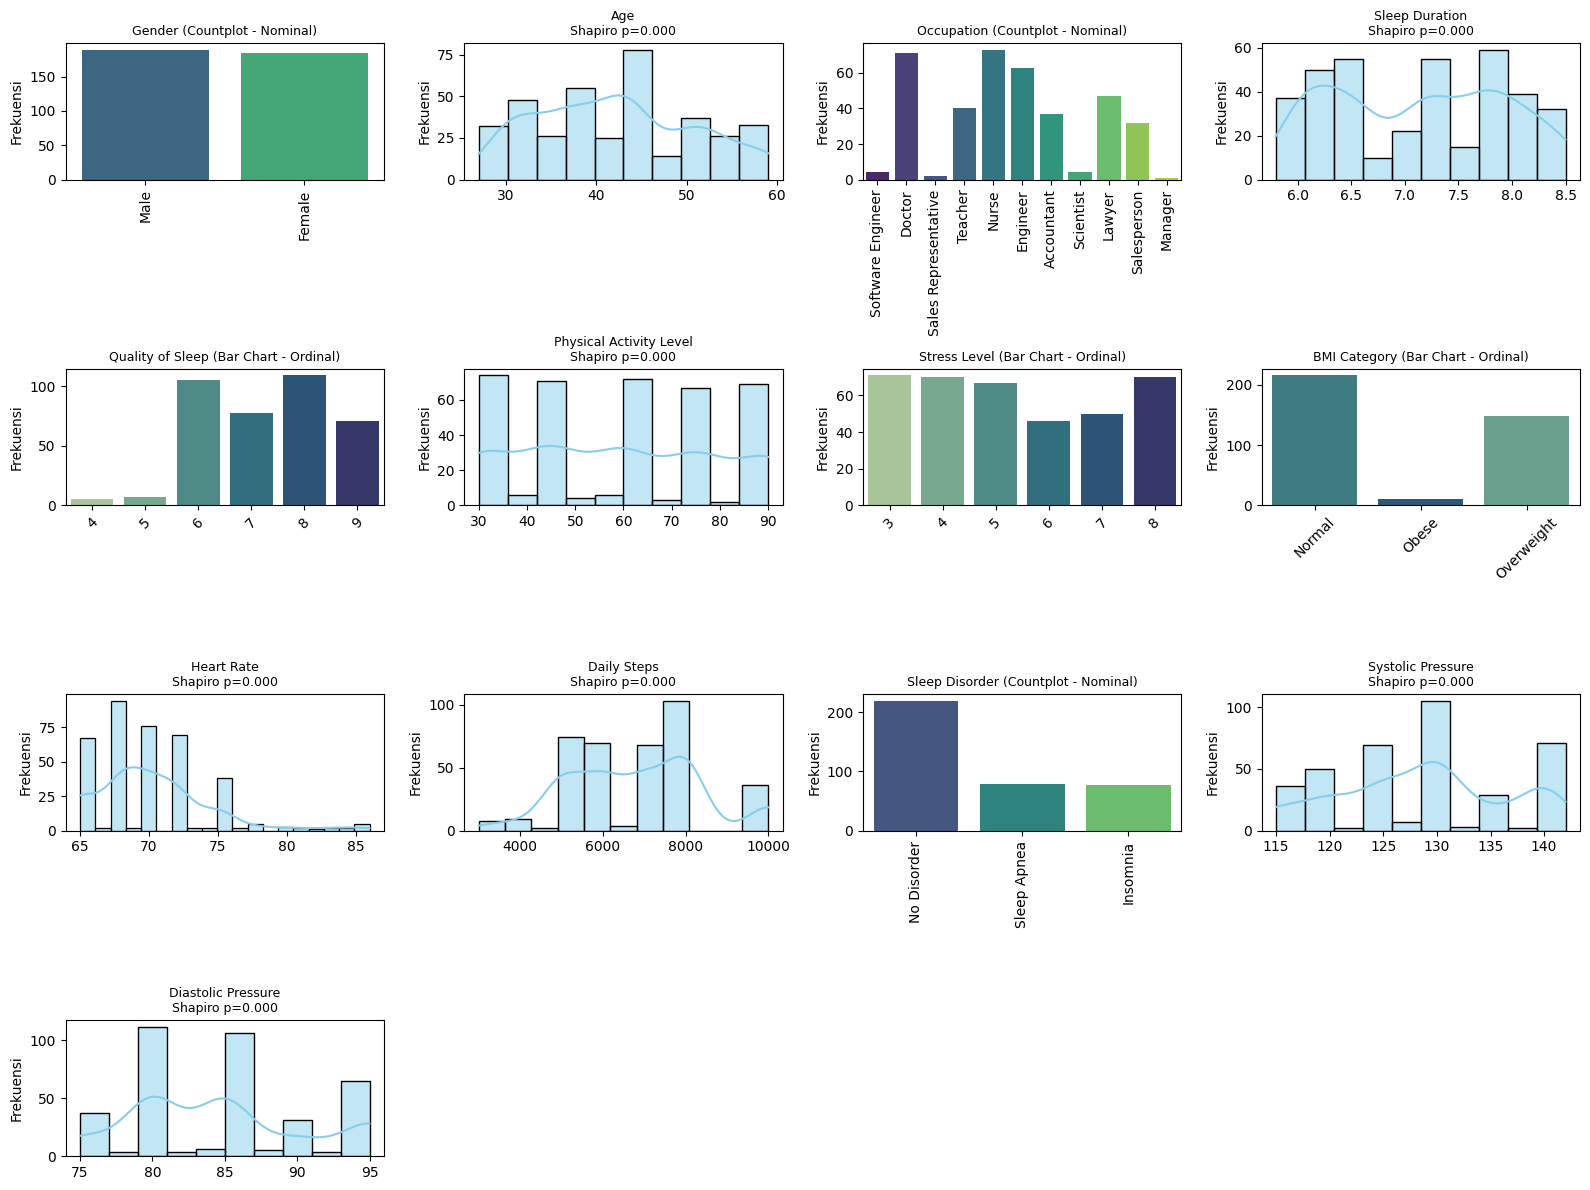

In [10]:
cols = 4
num_vars = len(df_corr.columns)
rows = (num_vars + cols - 1) // cols

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(df_corr.columns, 1):
    plt.subplot(rows, cols, i)
    scale = scale_map.get(col, 'Rasio') 

    if scale in ['Rasio', 'Interval']:
        data = df_corr[col].dropna()
        stat, p_val = shapiro(data)

        sns.histplot(data, kde=True, color='skyblue', edgecolor='black')
        plt.title(f"{col}\nShapiro p={p_val:.3f}", fontsize=9)
        plt.xlabel('')
        plt.ylabel('Frekuensi')

    elif scale == 'Ordinal':
        order = sorted(df_corr[col].dropna().unique())
        sns.countplot(x=col, hue=col, data=df_corr, order=order, palette='crest', legend=False)
        plt.title(f"{col} (Bar Chart - Ordinal)", fontsize=9)
        plt.xticks(rotation=45)

    elif scale == 'Nominal':
        sns.countplot(x=col, hue=col, data=df_corr, palette='viridis', legend=False)
        plt.title(f"{col} (Countplot - Nominal)", fontsize=9)
        plt.xticks(rotation=90)

    plt.xlabel('')
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [11]:
df_corr.describe(include='object')

,Gender,Occupation,BMI Category,Sleep Disorder
count,374,374,374,374
unique,2,11,3,3
top,Male,Nurse,Normal,No Disorder
freq,189,73,216,219


In [12]:
df_corr.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic Pressure,Diastolic Pressure
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920,128.553476,84.649733
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679,7.748118,6.161611
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000,115.000000,75.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000,125.000000,80.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000,130.000000,85.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000,135.000000,90.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000,142.000000,95.000000


#### Uji Normalitas Shapiro-Wilk

**Hipotesis:**

- **H₀ (Hipotesis nol):** Data berasal dari distribusi normal.  
- **H₁ (Hipotesis alternatif):** Data **tidak** berasal dari distribusi normal.

**p-value:**

- **p > 0.05:** Gagal menolak H₀ → data tidak berbeda signifikan dari normal → dianggap **normal**.  
- **p ≤ 0.05:** Tolak H₀ → data berbeda signifikan dari normal → dianggap **tidak normal**.

**Kesimpulan**  
P-value < 0.05 untuk semua variabel Rasio/Interval, sehingga **tidak ada variabel yang berdistribusi normal**.

### Analisis Korelasi

| Tipe Variabel  | Kuantitatif                           | Ordinal                   | Nominal                 |
| -------------- | ------------------------------------- | ------------------------- | ----------------------- |
| **Kuantiatif (X)** | Pearson r / Spearman rs / Kendall tau | -                         | -                       |
| **Ordinal (X)**    | Biserial rb                           | Spearman rs / Kendall tau | -                       |
| **Nominal (X)**    | Point biserial rpb                    | Rank biserial rrb         | Phi, Cramer’s V, Lambda |


| Variabel X                | Variabel Y            | Distribusi / Normalitas              | Linearitas | Jumlah Kategori / Sampel | Metode Analisis Korelasi / Uji      | Keterangan Singkat                                                     |
| ------------------------- | --------------------- | ------------------------------------ | ---------- | ------------------------ | ----------------------------------- | ---------------------------------------------------------------------- |
| Rasio / Interval      | Rasio / Interval  | Normal                               | Linear     | -                        | **Pearson’s r**                     | Kekuatan & arah hubungan linear antar dua variabel kontinu.            |
| Rasio / Interval          | Rasio / Interval      | Tidak normal                         | Monotonik  | -                        | **Spearman’s ρ** / **Kendall’s τ**  | Nonparametrik, cocok untuk data tidak normal atau hubungan non-linear. |
| Rasio / Interval          | Nominal (2 kategori)  | Normal                               | -          | Dua kategori             | **Point Biserial (rₚb)**            | Versi Pearson untuk variabel biner (0/1).                              |
| Rasio / Interval          | Nominal (2 kategori)  | Tidak normal                         | -          | Dua kategori, n kecil    | **Mann–Whitney U Test**             | Nonparametrik pengganti t-test.                                        |
| Rasio / Interval          | Nominal (>2 kategori) | Normal, homogen                      | -          | ≥3 kategori              | **One-way ANOVA**                   | Uji beda rata-rata antar kelompok kategori.                            |
| **Rasio / Interval**          | **Nominal (>2 kategori)** | **Tidak normal / varians tidak homogen** | -          | **≥3 kategori**              | **Kruskal–Wallis Test**             | **Nonparametrik pengganti ANOVA.**                                         |
| Ordinal                   | Ordinal               | -                                    | Monotonik  | -                        | **Spearman’s ρ / Kendall’s τ**      | Korelasi ranking antar dua variabel ordinal.                           |
| Ordinal                   | Nominal (2 kategori)  | -                                    | -          | Dua kategori             | **Rank Biserial (rᵣb)**             | Hubungan ranking dengan variabel biner.                                |
| **Ordinal**                   | **Nominal (>2 kategori)** | -                 | -          | **≥3 kategori**              | **Kruskal–Wallis Test**             | **Bandingkan ranking antar banyak kategori.**|
| Nominal (2 kategori)      | Nominal (2 kategori)  | -                                    | -          | n kecil                  | **Fisher’s Exact Test**             | Tepat untuk tabel 2x2 dengan sampel kecil.                             |
| Nominal (2 kategori)      | Nominal (2 kategori)  | -                                    | -          | n besar                  | **Chi-Square Test**                 | Uji asosiasi antar dua variabel kategori.                              |
| **Nominal (>2 kategori)**     | **Nominal (>2 kategori)** | -                                    | -          | **≥3 kategori**              | **Cramer’s V / Lambda**             | **Ukur kekuatan asosiasi antar variabel kategorik.**                       |
| Rasio / Interval (banyak) | Nominal (2 kategori)  | -                                    | -          | Dua kategori             | **Binary Logistic Regression**      | Prediksi kategori biner dari variabel kontinu.                         |
| Rasio / Interval (banyak) | Nominal (>2 kategori) | -                                    | -          | ≥3 kategori              | **Multinomial Logistic Regression** | Prediksi kategori multinomial (misal Sleep Disorder).                  |


| Kolom                   | Deskripsi                                                           | Skala   | Metode Analisis Korelasi        |
| ----------------------- | ------------------------------------------------------------------- | ------- | ------------------------------- |
| Gender                  | Jenis kelamin orang (Laki-laki/Perempuan)                           | Nominal | Cramer’s V                      |
| Age                     | Usia orang dalam tahun                                              | Rasio   | Kruskal–Wallis Test |
| Occupation              | Pekerjaan atau profesi orang                                        | Nominal |  Cramer’s V                         |
| Sleep Duration          | Jumlah jam tidur per hari                                           | Rasio   | Kruskal–Wallis Test |
| Quality of Sleep        | Penilaian subjektif kualitas tidur (1-10)                           | Ordinal | Kruskal–Wallis Test                          |
| Physical Activity Level | Jumlah menit aktivitas fisik per hari                               | Rasio   | Kruskal–Wallis Test |
| Stress Level            | Penilaian subjektif tingkat stres (1-10)                            | Ordinal | Kruskal–Wallis Test                          |
| BMI Category            | Kategori BMI                                             | Ordinal | Kruskal–Wallis Test                 |
| Heart Rate              | Detak jantung istirahat per menit                                   | Rasio   | Kruskal–Wallis Test |
| Daily Steps             | Jumlah langkah per hari                                             | Rasio   | Kruskal–Wallis Test |
| Sleep Disorder          | Ada atau tidaknya gangguan tidur (Tidak ada, Insomnia, Sleep Apnea) | Nominal | Dependen                        |
| Systolic Pressure       | Tekanan darah sistolik                                              | Rasio   | Kruskal–Wallis Test |
| Diastolic Pressure      | Tekanan darah diastolik                                             | Rasio   | Kruskal–Wallis Test |

#### Analisis Korelasi Variabel Ordinal

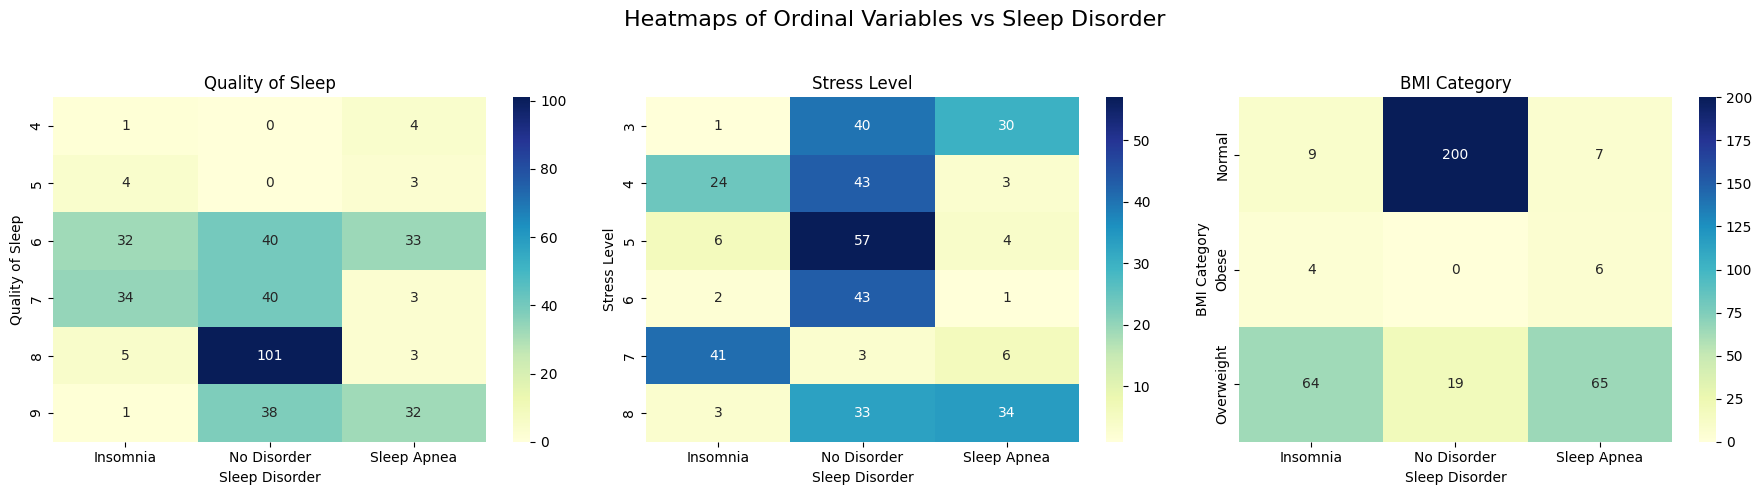

In [13]:
ordinal_vars = [var for var, scale in scale_map.items() if scale == 'Ordinal']

fig, axes = plt.subplots(1, len(ordinal_vars), figsize=(18, 5))

for ax, col in zip(axes, ordinal_vars):
    freq_table = pd.crosstab(df[col], df['Sleep Disorder'])

    sns.heatmap(
        freq_table,
        annot=True,
        fmt='d',
        cmap='YlGnBu',
        ax=ax
    )

    ax.set_title(col)
    ax.set_xlabel('Sleep Disorder')
    ax.set_ylabel(col)

fig.suptitle('Heatmaps of Ordinal Variables vs Sleep Disorder', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
results = []
for var in ordinal_vars:
    groups = [df[df[target] == cat][var].dropna() for cat in df[target].unique()]
    stat, p = kruskal(*groups)
    
    results.append({
        'Variable': var,
        'Kruskal-Wallis H': stat,
        'p-value': p,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No'
    })

df_kw_ordinal = pd.DataFrame(results)
print(df_kw_ordinal)

           Variable  Kruskal-Wallis H       p-value Significant (α=0.05)
0  Quality of Sleep         49.178905  2.093806e-11                  Yes
1      Stress Level         10.042155  6.597414e-03                  Yes
2      BMI Category        235.797812  6.268385e-52                  Yes


* **Jika p-value < α (misal 0.05)** → hubungan signifikan → ada indikasi variabel X berhubungan dengan variabel Y.
* **Jika p-value ≥ α** → tidak signifikan → tidak ada bukti hubungan.

Quality of Sleep vs Sleep Disorder: Nilai p-value sangat kecil (2.09×10⁻¹¹ < 0.05), menunjukkan terdapat hubungan yang signifikan antara kualitas tidur dan jenis gangguan tidur. Artinya, distribusi ranking kualitas tidur berbeda secara signifikan antar kategori Sleep Disorder (No Disorder, Insomnia, Sleep Apnea).

Stress Level vs Sleep Disorder: Nilai p-value juga lebih kecil dari 0.05 (6.59×10⁻³), menunjukkan ada hubungan yang signifikan antara tingkat stres dan jenis gangguan tidur. Distribusi ranking tingkat stres berbeda secara signifikan antar kategori Sleep Disorder.

#### Analisis Korelasi Variabel Nominal

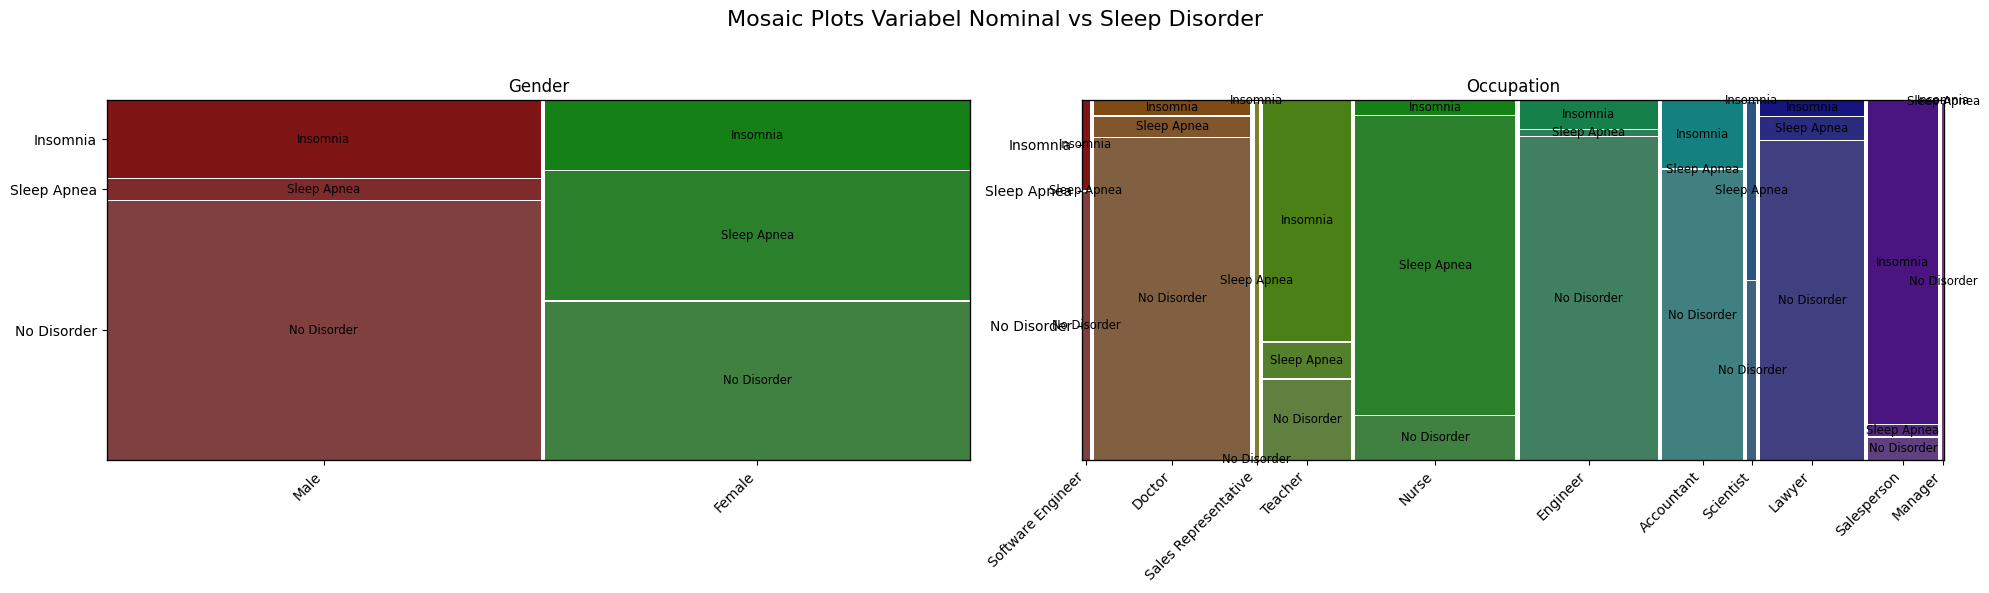

In [24]:
nominal_vars = ['Gender', 'Occupation']
fig, axes = plt.subplots(1, len(nominal_vars), figsize=(20, 6))

for ax, col in zip(axes, nominal_vars):
    mosaic(
        df,
        [col, 'Sleep Disorder'],
        ax=ax,
        labelizer=lambda k: k[1],
        properties={'fontsize': 8}
    )
    ax.set_title(col)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')

fig.suptitle('Mosaic Plots Variabel Nominal vs Sleep Disorder', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency.shape)-1)))

results = []
for col in nominal_vars:
    cv = cramers_v(df[col], df[target])
    results.append({'Variable': col, "Cramer's V": cv})

df_cramers = pd.DataFrame(results)
print(df_cramers)

     Variable  Cramer's V
0      Gender    0.381055
1  Occupation    0.750546


| Cramer’s V  | Kekuatan hubungan (rule of thumb) |
| ----------- | --------------------------------- |
| 0.00 – 0.10 | Sangat lemah / hampir tidak ada   |
| 0.10 – 0.30 | Lemah                             |
| 0.30 – 0.50 | Sedang                            |
| 0.50 – 0.70 | Kuat                              |
| 0.70 – 1.00 | Sangat kuat                       |


Semua variabel nominal yang dianalisis memiliki hubungan dengan Sleep Disorder, dengan kekuatan bervariasi: Occupation paling berpengaruh, diikuti BMI, lalu Gender.

#### Analisis Korelasi Variabel Kontinu

In [17]:
print(numerical_vars)

['Age', 'Sleep Duration', 'Physical Activity Level', 'Heart Rate', 'Daily Steps', 'Systolic Pressure', 'Diastolic Pressure']


C:\Users\pc\AppData\Local\Temp\ipykernel_4532\4117362876.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
C:\Users\pc\AppData\Local\Temp\ipykernel_4532\4117362876.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
C:\Users\pc\AppData\Local\Temp\ipykernel_4532\4117362876.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
C:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 42.5% of the points cannot be placed; you may want to decrease the size of the markers or use st

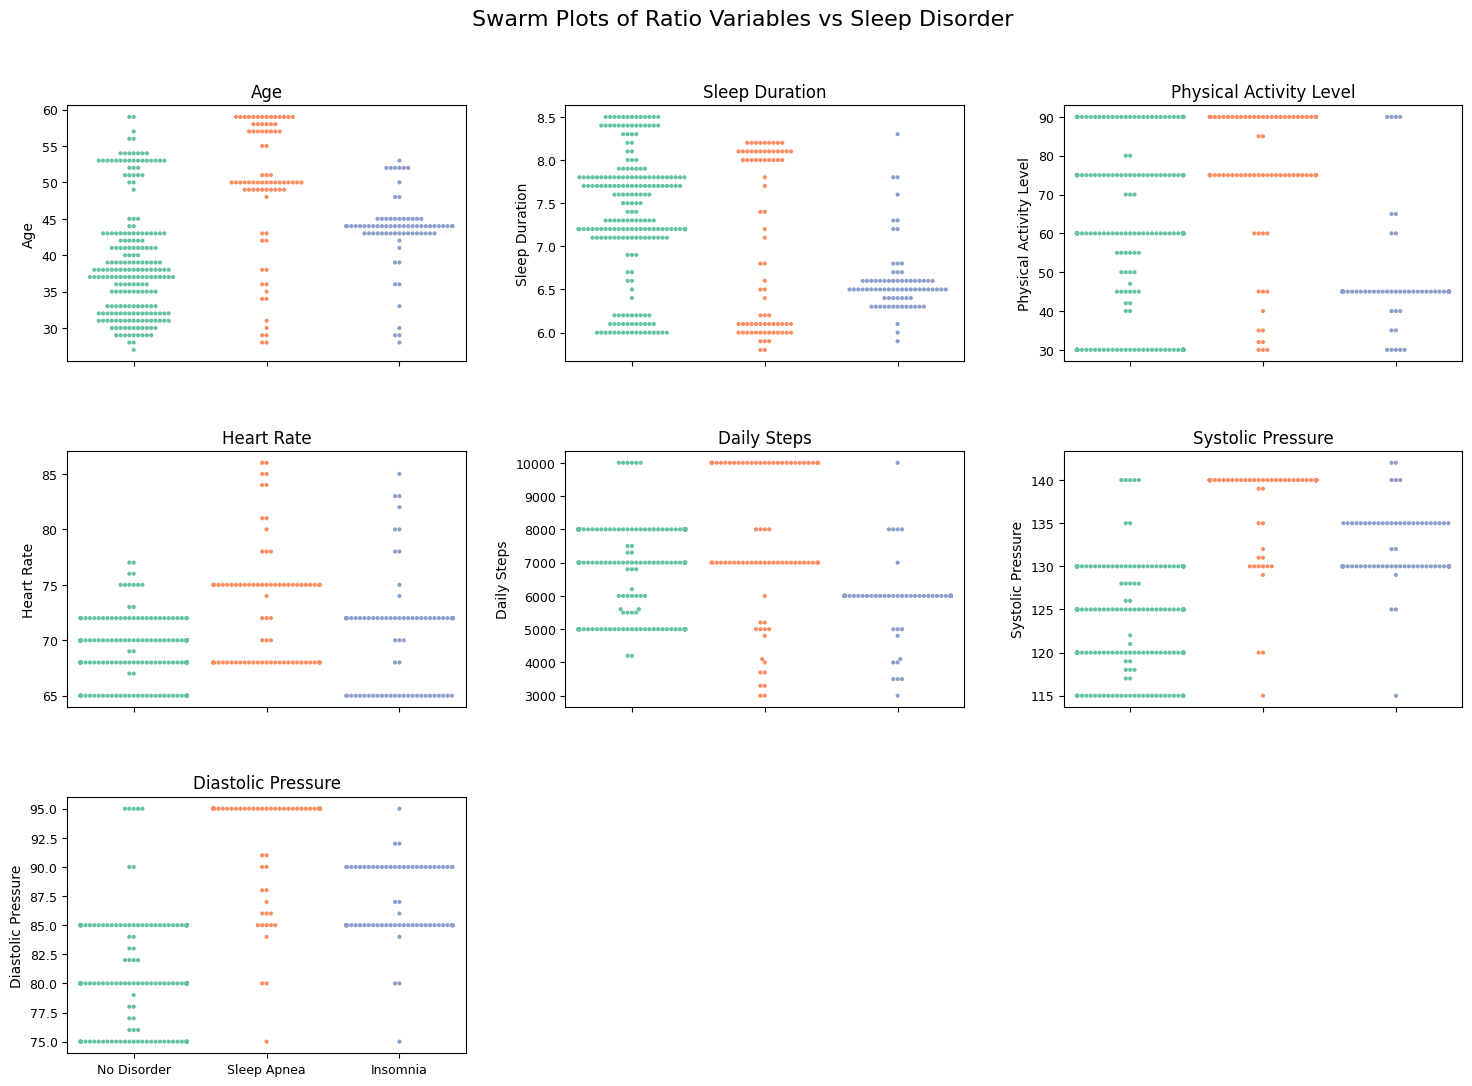

In [19]:
# import math

# n_vars = len(numerical_vars)
# n_cols = 3
# n_rows = math.ceil(n_vars / n_cols)

# fig, axes = plt.subplots(
#     n_rows, n_cols,
#     figsize=(18, 4 * n_rows),
#     sharex=True
# )

# axes = axes.flatten()

# for i, col in enumerate(numerical_vars):
#     sns.swarmplot(
#         x='Sleep Disorder',
#         y=col,
#         data=df,
#         ax=axes[i],
#         palette='Set2',
#         size=3
#     )
#     axes[i].set_title(col, fontsize=12)
#     axes[i].set_xlabel('')                
#     axes[i].set_ylabel(col, fontsize=10)
#     axes[i].tick_params(axis='x', labelsize=9)
#     axes[i].tick_params(axis='y', labelsize=9)

# for j in range(n_vars, len(axes)):
#     fig.delaxes(axes[j])

# fig.suptitle('Swarm Plots Variabel Rasio vs Sleep Disorder', fontsize=16)
# plt.subplots_adjust(
#     hspace=0.35,
#     wspace=0.25,
#     top=0.90
# )
# plt.show()

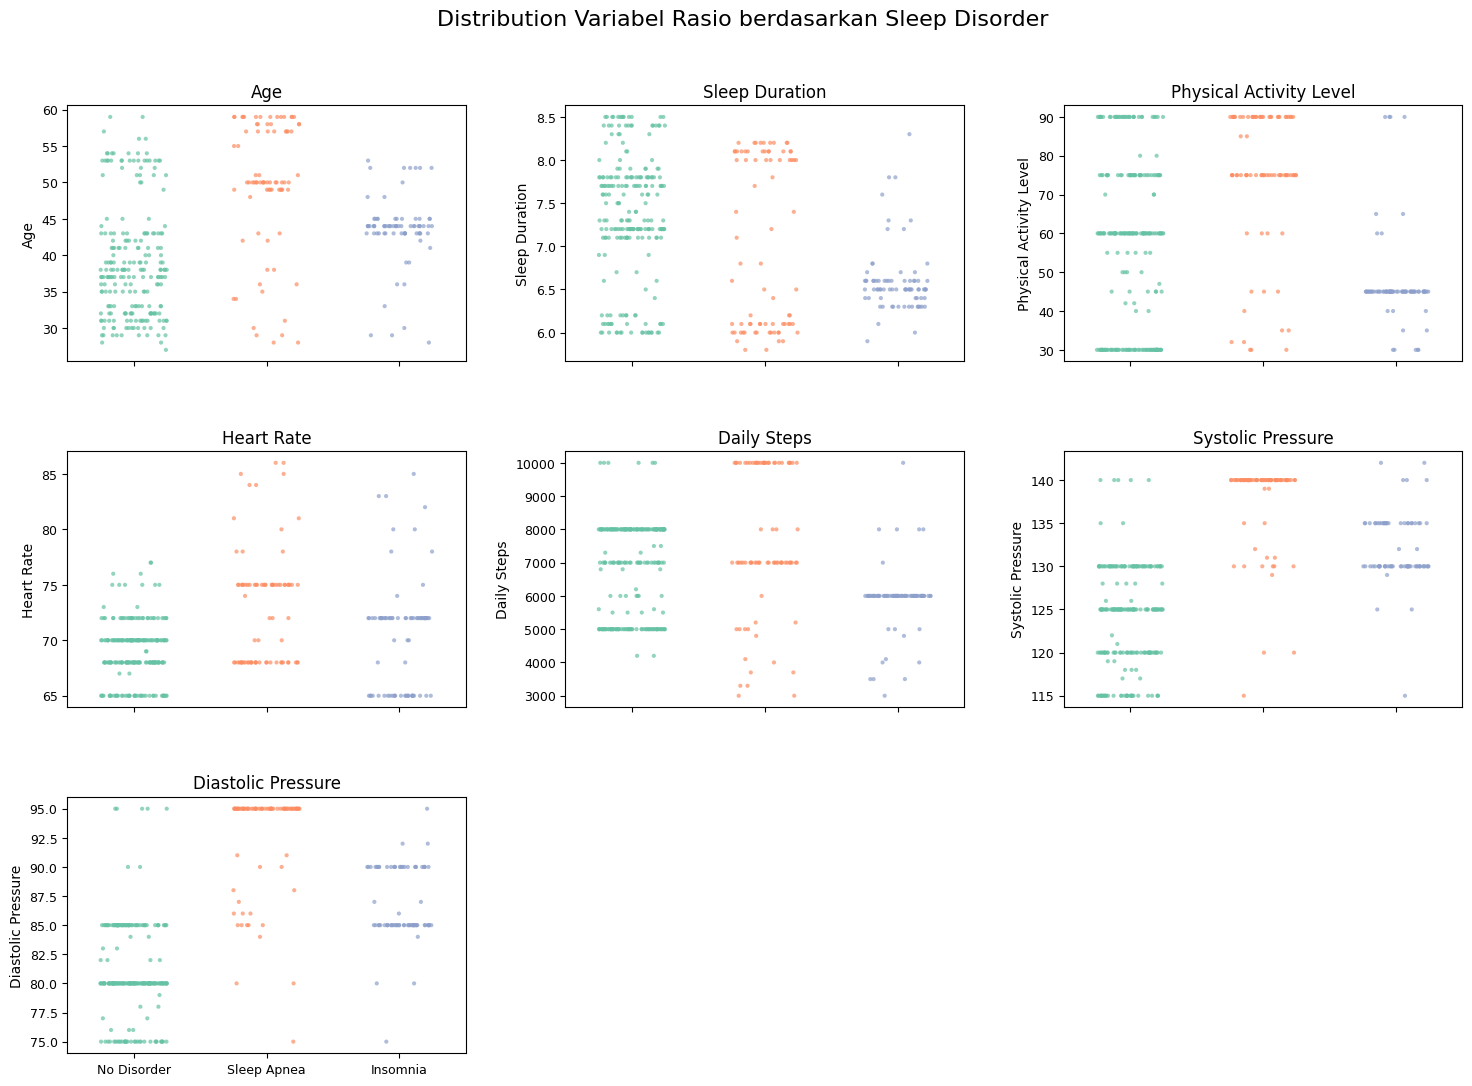

In [21]:
n_vars = len(numerical_vars)
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(18, 4 * n_rows),
    sharex=True
)

axes = axes.flatten()

for i, col in enumerate(numerical_vars):
    sns.stripplot(
        data=df,
        x='Sleep Disorder',
        y=col,
        hue='Sleep Disorder',
        ax=axes[i],
        palette='Set2',
        legend=False,
        jitter=0.25,   
        size=3,
        alpha=0.7
    )

    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)

for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    'Distribution Variabel Rasio berdasarkan Sleep Disorder',
    fontsize=16,
    y=0.98
)

plt.subplots_adjust(
    hspace=0.35,
    wspace=0.25,
    top=0.90
)

plt.show()

In [ ]:
import pandas as pd

results = []

for col in numerical_vars:
    # Buat list nilai numerik per kategori target
    groups = [df_corr[df_corr[target]==cat][col].dropna() for cat in df_corr[target].unique()]
    
    stat, p = kruskal(*groups)
    results.append({
        'Variable': col,
        'Kruskal-Wallis H': stat,
        'p-value': p,
        'Significant (α=0.05)': 'Yes' if p < 0.05 else 'No'
    })

kruskal_df = pd.DataFrame(results)
kruskal_df


Semua variabel numerik menunjukkan **hubungan signifikan** dengan Sleep Disorder karena **p-value < 0.05**. Artinya, faktor-faktor seperti umur, jam tidur, aktivitas fisik, detak jantung, jumlah langkah, dan tekanan darah **berkaitan dengan jenis gangguan tidur**, ditandai dengan perbedaan distribusi variabel-variabel ini antar kategori Sleep Disorder.


### Analisis Regresi Logistik Multinomial

In [ ]:
df_enc = df.copy()
df_enc.info()

In [ ]:
df['Occupation'].unique()
df['Occupation'].value_counts()

In [ ]:
df_enc = df.copy()
cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'] # cols: ordinal & nominal
for col in cols:
    if col in ['Occupation', 'BMI Category']:
        print(col)
        baseline = df_enc[col].value_counts().idxmax() # Nurse 
        dummies = pd.get_dummies(df_enc[col], drop_first=False)
        dummies = dummies.drop(columns=[baseline])
        df_enc = pd.concat([df_enc.drop(columns=[col]), dummies], axis=1)
    else:
        le = LabelEncoder()
        df_enc[col] = le.fit_transform(df[col])
        print(f'{col}: {df_enc[col].unique()}')
        print(le.classes_)
        print()

karena jarak level bmi nya jauh, maka perlu didummy kan <br>
pertimbangan:
- sleep disorder dikira ordinal
- bmi category belum ada data yg benar

#### Cek Multikolinearitas

In [ ]:
X_vif = df_enc.drop(columns=['Person ID', 'Blood Pressure', target]).astype(float)
X_vif = add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

In [ ]:
df_novif = df_enc.drop(columns=['Person ID', 'Blood Pressure', 'Sleep Disorder','Gender','Age', 'Sleep Duration', 'Quality of Sleep', 'Daily Steps', 
                                'Stress Level', 'Heart Rate', 'Systolic Pressure', 'Diastolic Pressure', 'Doctor', 'Engineer', 'Overweight'])

In [ ]:
rasio_cols = [
    # 'Age', 'Sleep Duration','Heart Rate','Systolic Pressure', 'Diastolic Pressure','Daily Steps',
    'Physical Activity Level',  ]

scaler = StandardScaler()
df_novif[rasio_cols] = scaler.fit_transform(df_novif[rasio_cols])

ordinal dlm regresi tidak perlu di standarisasi

In [ ]:
X = df_novif.astype(float)
y = df_enc[target]

In [ ]:
X.head(2)

In [ ]:
pd.crosstab([X['Obese'], X['Software Engineer']], y)

In [ ]:
X.isnull().sum()
y.isnull().sum()

y.value_counts()

In [ ]:
y_cat = y.astype('category')
y_cat = y_cat.cat.reorder_categories([1, 0, 2], ordered=True)
print("Urutan kategorinya:", y_cat.cat.categories)

X_const = add_constant(X, prepend=True)

In [ ]:
mnlogit_model = sm.MNLogit(y_cat, X_const)
mnlogit_result = mnlogit_model.fit_regularized()

In [ ]:
print(mnlogit_result.summary())

In [ ]:
X_sig = X[['Physical Activity Level','Accountant','Lawyer','Salesperson', 'Scientist', 'Teacher']]
X_const2 = add_constant(X_sig, prepend=True)
mnlogit_model2 = sm.MNLogit(y_cat, X_const2)
mnlogit_result2 = mnlogit_model2.fit_regularized()
print(mnlogit_result2.summary())

In [ ]:
ll_full = mnlogit_result2.llf   # Log-likelihood model penuh (setelah fitting)
ll_null = mnlogit_result2.llnull  # Log-likelihood model kosong (null model)
N = len(X_sig)  

pseudo_r2_mcfadden = 1 - (ll_full / ll_null)
pseudo_r2_cox_snell = 1 - (ll_full / ll_null) ** (2 / N)
pseudo_r2_nagelkerke = pseudo_r2_cox_snell / (1 - (ll_null / ll_full) ** (2 / N))

pseudo_r2_results = pd.DataFrame({
    'Pseudo R² Type': ['McFadden', 'Cox and Snell', 'Nagelkerke'],
    'Value': [pseudo_r2_mcfadden, pseudo_r2_cox_snell, pseudo_r2_nagelkerke]
})
aic = mnlogit_result2.aic
bic = mnlogit_result2.bic
print(f"AIC: {aic}")
print(f"BIC: {bic}")

In [ ]:
pseudo_r2_results

In [ ]:
null_model = sm.MNLogit(y_cat, sm.add_constant(np.ones(len(X_sig))))
null_result = null_model.fit()

G_stat = 2 * (ll_full - ll_null)
df_diff = len(mnlogit_result2.params) - len(null_result.params) 
p_value_g = 1 - stats.chi2.cdf(G_stat, df_diff)

print(f"G-test statistic: {G_stat}")
print(f"P-value for G-test: {p_value_g}")

### Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv(f'data/Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
if 'Blood Pressure' in df.columns:
    bp_split = df['Blood Pressure'].str.split('/', expand=True)
    df['Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
    df['Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
    df.drop(columns=['Blood Pressure'], inplace=True)

df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')

bmi_mapping = {'Normal': 0,
               'Overweight': 1,
               'Obese': 2}
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
print(df['BMI Category'].unique())
df['BMI Category'] = df['BMI Category'].map(bmi_mapping)

In [ ]:
X = df.drop(columns=['Person ID', 'Sleep Disorder'])
y = df['Sleep Disorder']

print("Fitur:", X.columns.tolist())
print("Target size:", y.shape)
X.info()

In [ ]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
label_encoders = {}
for col in cat_cols:
    le_col = LabelEncoder()
    X[col] = le_col.fit_transform(X[col])
    label_encoders[col] = le_col

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)
class_labels = le_y.classes_ 
print("Kelas target:", class_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
models = {
    "Naive Bayes (GaussianNB)": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42)
}

In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Bisa juga 'macro' atau 'micro' tergantung kebutuhan
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    if len(y_pred_proba.shape) == 2: 
        if y_pred_proba.shape[1] == 3: 
            auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
        else:
            print("Warning: Unexpected number of classes in prediction probabilities.")
            auc_roc = None
    else:  
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    print("="*60)
    print(f"Model: {name}")
    print(f"Akurasi: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_y.classes_))
    
    print("Confusion Matrix:")
    plt.figure(figsize=(6, 5))  # Ukuran gambar (lebar, tinggi)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels, 
                cbar=False)
    plt.title(f"Confusion Matrix {name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    # print(confusion_matrix(y_test, y_pred))

    report = classification_report(y_test, y_pred, target_names=le_y.classes_, output_dict=True)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    })

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print("\n===== Ringkasan Hasil 5 Model =====")
print(results_df)


In [ ]:
rf_name, rf_model = list(models.items())[2]
tree_estimator = rf_model.estimators_[0]

plt.figure(figsize=(30,15))
plot_tree(
    tree_estimator,
    feature_names=X_train_scaled.columns,
    class_names=le_y.classes_,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()